In [1]:
# Load environment variables from .env file
from dotenv import load_dotenv
import os

load_dotenv()

# Access the variables
MY_USER_ID = os.getenv("MY_USER_ID")
METEA_LEAGUE_ID = os.getenv("METEA_LEAGUE_ID")
OSU_LEAGUE_ID = os.getenv("OSU_LEAGUE_ID")

In [2]:
# import necessary packages
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd

# set API values
user_id = MY_USER_ID
league_id = OSU_LEAGUE_ID

# open Player data json file
players_file = open('Players.json')
players_data = json.load(players_file)

In [3]:
# get league info
year = 2023
response = requests.get('https://api.sleeper.app/v1/user/{}/leagues/nfl/{}'.format(user_id,year)).text
#print (json.dumps(response.json(), indent=4, sort_keys=True))
leagues_info = json.loads(response)

In [4]:
# Functions to Use

# Create an anonymized mapping with user names and id's
def anonymize_data(user_info):
    anonymized_mapping = {}  # To store the mapping of original to anonymized data
    counter = 1
    
    for user_id, display_name in user_info.items():
        anonymized_user_id = f"User_{counter}"
        
        # Store the mapping
        anonymized_mapping[anonymized_user_id] = (user_id, display_name)  # Map anonymized name to original data
        
        counter += 1
    
    return anonymized_mapping

# Function to get User Number from Display Name
def get_user_number(display_name):
    for user_number, (user_id, name) in anonymized_mapping.items():
        if name == display_name:
            return user_number
    return None  # Return None if display name not found

In [5]:
# get users info in the league
response = requests.get('https://api.sleeper.app/v1/league/{}/users'.format(league_id)).text
league_info = json.loads(response)

user_info = {}
for user in league_info:
    user_info[user['user_id']] = user['display_name']

anonymized_mapping = anonymize_data(user_info)

In [6]:
# get rosters in a league
response = requests.get('https://api.sleeper.app/v1/league/{}/rosters'.format(league_id)).text
roster_info = json.loads(response)

rosters = {}
for r in roster_info:
    rosters[r['roster_id']] = r['owner_id']

In [7]:
# Bool Toggle to set if user names should be anonymous or not
useAnonymousUsers = True

# set up DataFrame
df = pd.DataFrame(
    {
        "Team": [],
        "Player": [],
        "Age": [],
        "Position": [],
    }
)

for r in roster_info:
    team_user = user_info[rosters[r['roster_id']]]
    if useAnonymousUsers:
        team_user = get_user_number(team_user)

    for s in r['players']:
        if players_data[s]['position'] not in  ['DEF','K']:
            df.loc[len(df.index)] = [
                team_user,
                players_data[s]['full_name'],
                players_data[s]['age'],
                players_data[s]['position']
            ]
df

,Team,Player,Age,Position
0,User_1,Odell Beckham,30.0,WR
1,User_1,Brandin Cooks,29.0,WR
2,User_1,Demarcus Robinson,28.0,WR
3,User_1,Mike Williams,28.0,WR
4,User_1,Josh Reynolds,28.0,WR
...,...,...,...,...
251,User_12,Daniel Bellinger,22.0,TE
252,User_12,Puka Nacua,22.0,WR
253,User_12,Marvin Mims,21.0,WR
254,User_12,Demario Douglas,22.0,WR


In [8]:
# send df to CSV
df.to_csv('OSU_anon_roster_ages')

In [9]:
# get the average age for each team
df_total_avg = df.groupby('Team').mean().sort_values('Age')
df_total_avg

,Age
Team,
User_6,23.315789
User_5,24.086957
User_12,24.272727
User_3,24.300000
User_10,24.850000
User_4,25.000000
User_1,25.347826
User_7,25.608696
User_2,25.761905


In [10]:
# get the average age for each team by position
df_pos_avg = df.groupby(['Team','Position']).mean()
df_pos_avg

Age
Team    Position           
User_1  QB        30.000000
        RB        23.777778
        TE        25.666667
        WR        25.777778
User_10 QB        24.333333
        RB        25.000000
        TE        26.500000
        WR        24.000000
User_11 QB        26.000000
        RB        26.166667
        TE        27.000000
        WR        26.000000
User_12 QB        28.000000
        RB        24.285714
        TE        24.000000
        WR        23.111111
User_13 QB        28.000000
        RB        26.000000
        TE        29.500000
        WR        25.636364
User_2  QB        29.333333
        RB        25.125000
        TE        25.500000
        WR        25.125000
User_3  QB        24.500000
        RB        24.000000
        TE        25.000000
        WR        24.333333
User_4  QB        27.400000
        RB        24.200000
        TE        23.500000
        WR        24.750000
User_5  QB        25.750000
        RB        23.375000
        TE        22.500000
        WR        24.333333
User_6  QB        23.000000
        RB        23.200000
        TE        24.500000
        WR        23.222222
User_7  QB        26.333333
        RB        24.875000
        TE        24.000000
        WR        26.555556
User_8  QB        28.000000
        RB        24.875000
        TE        27.750000
        WR        25.000000

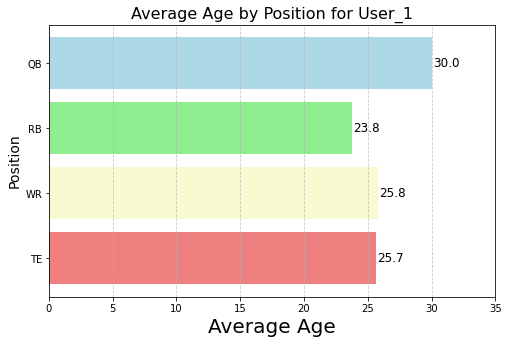

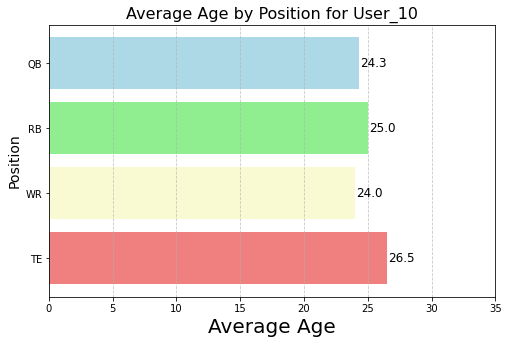

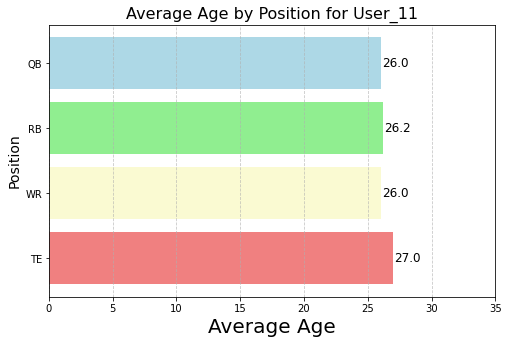

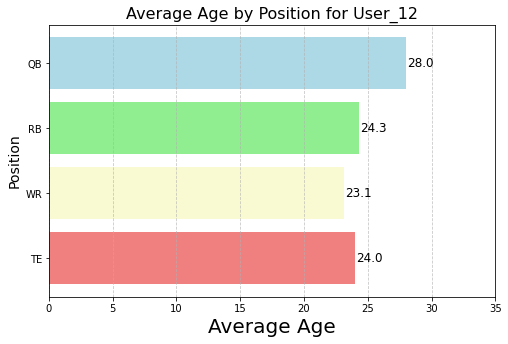

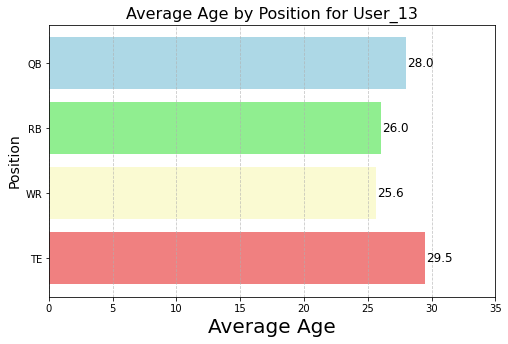

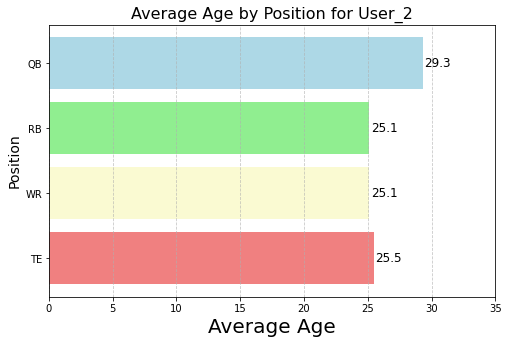

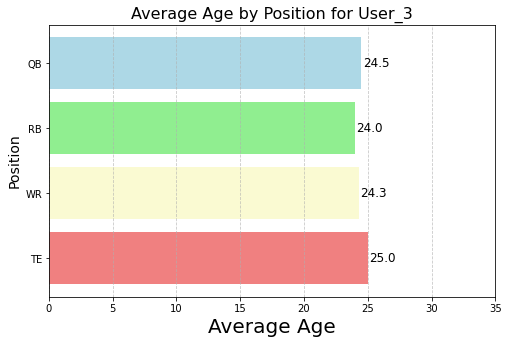

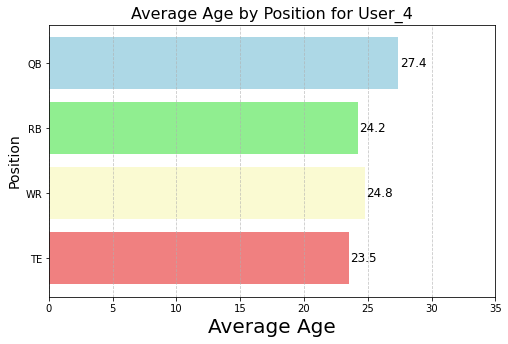

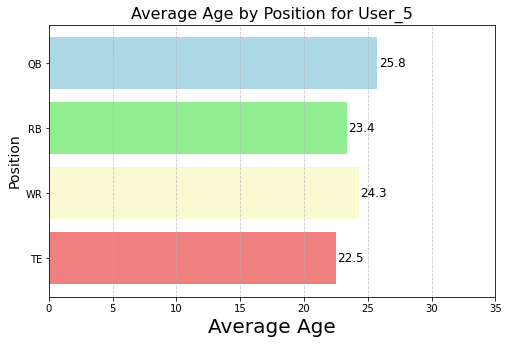

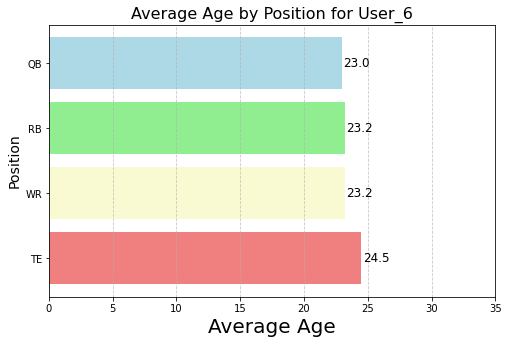

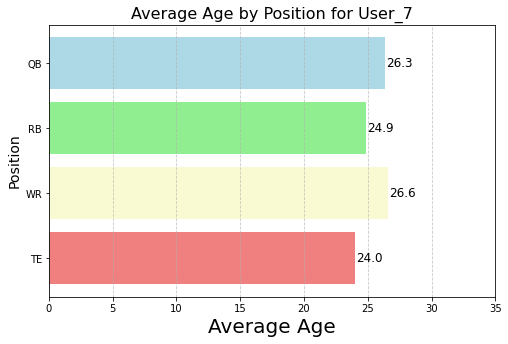

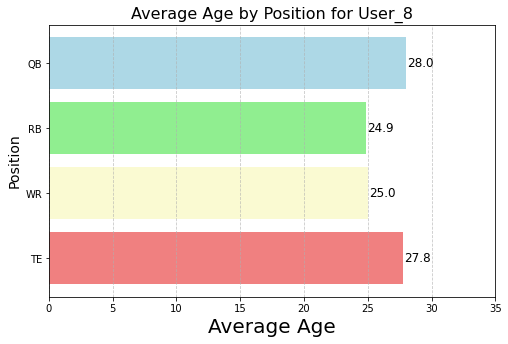

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_pos_avg has been defined previously with the necessary grouping
# Reset the index to make 'Team' and 'Position' regular columns
df_pos_avg = df_pos_avg.reset_index()

# Define the custom order for positions
position_order = ['QB', 'RB', 'WR', 'TE']

# Create a color map for the positions
colors = {
    "QB": "lightblue",
    "RB": "lightgreen",
    "WR": "lightgoldenrodyellow",
    "TE": "lightcoral"
}

# Get unique teams
teams = df_pos_avg['Team'].unique()

# Plotting for each team
for team in teams:
    # Filter data for the current team
    team_data = df_pos_avg[df_pos_avg['Team'] == team].copy()  # Use .copy() to avoid SettingWithCopyWarning
    
    # Convert the 'Position' column to a categorical type with the specified order
    team_data.loc[:, 'Position'] = pd.Categorical(team_data['Position'], categories=position_order, ordered=True)

    # Sort data by Position in the defined order
    team_data = team_data.sort_values('Position', ascending=False)

    # Create a horizontal bar plot for the current team's positions
    plt.figure(figsize=(8, 5))
    plt.barh(team_data['Position'], team_data['Age'], color=[colors[pos] for pos in team_data['Position']])
    
    # Add labels and title with increased font size
    plt.title(f'Average Age by Position for {team}', fontsize=16)
    plt.xlabel('Average Age', fontsize=20)
    plt.ylabel('Position', fontsize=14)

    # Add value labels to the bars with increased font size
    for index, value in enumerate(team_data['Age']):
        plt.text(value + 0.1, index, str(round(value, 1)), va='center', color='black', fontsize=12)

    plt.xlim(0, max(df_pos_avg['Age']) + 5)  # Adjust x-axis limit for better label visibility
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Show the plot for each team
    plt.show()

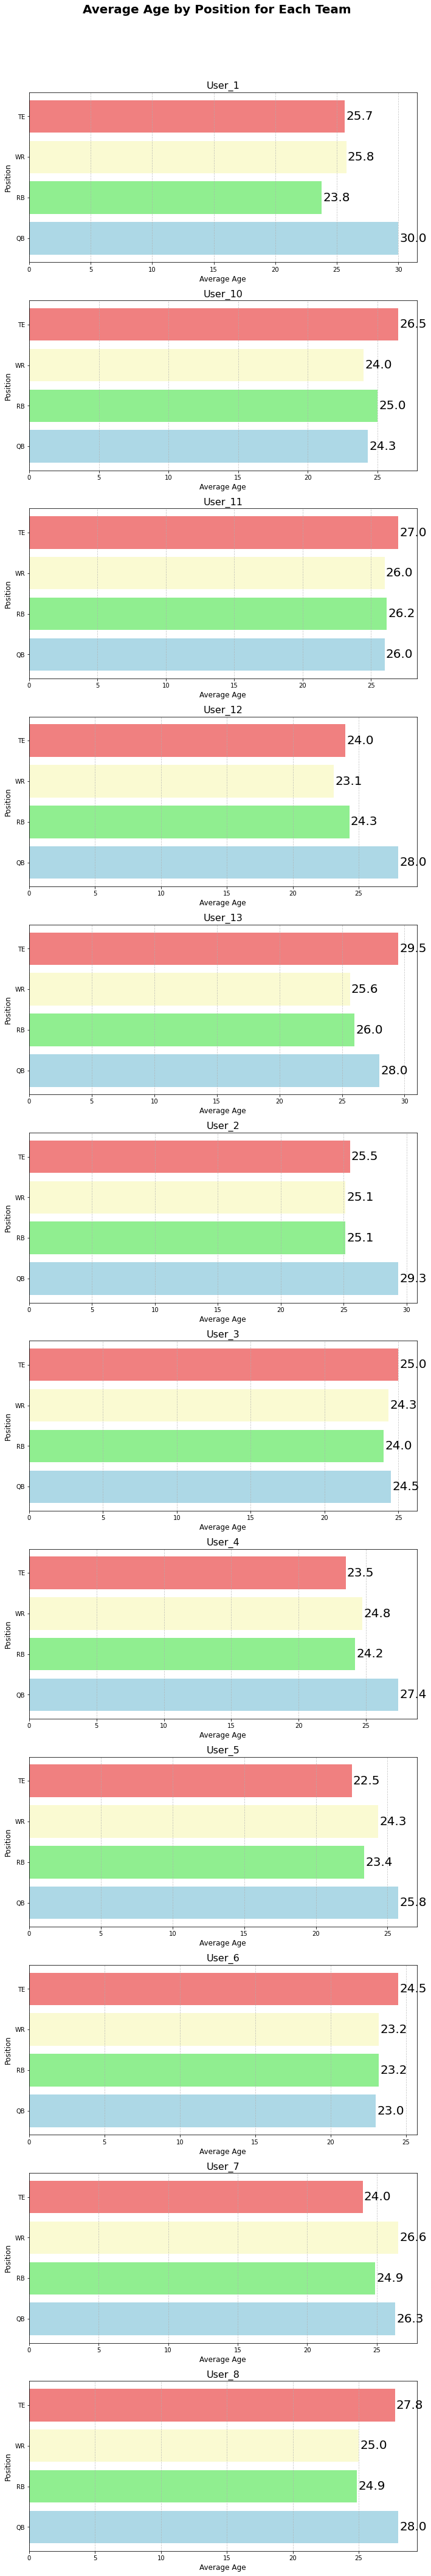

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_pos_avg has been defined previously with the necessary grouping
# Reset the index to make 'Team' and 'Position' regular columns
# df_pos_avg = df_pos_avg.reset_index()

# Define the custom order for positions
position_order = ['QB', 'RB', 'WR', 'TE']

# Create a color map for the positions
colors = {
    "QB": "lightblue",
    "RB": "lightgreen",
    "WR": "lightgoldenrodyellow",
    "TE": "lightcoral"
}

# Convert 'Position' to a categorical type with the specified order
df_pos_avg['Position'] = pd.Categorical(df_pos_avg['Position'], categories=position_order, ordered=True)

# Sort data by 'Team' and 'Position'
df_pos_avg = df_pos_avg.sort_values(['Team', 'Position'])

# Create subplots for each team
teams = df_pos_avg['Team'].unique()
num_teams = len(teams)

# Create a single column of subplots, one for each team
fig, axs = plt.subplots(num_teams, 1, figsize=(10, 5 * num_teams))

# Set the figure background color to white
fig.patch.set_facecolor('white')

# Plotting for each team
for idx, team in enumerate(teams):
    team_data = df_pos_avg[df_pos_avg['Team'] == team]
    
    # Create a horizontal bar plot for the current team's positions
    axs[idx].barh(team_data['Position'], team_data['Age'], color=[colors[pos] for pos in team_data['Position']])
    
    # Set the axes background color to white
    axs[idx].set_facecolor('white')

    # Add individual titles for each subplot
    axs[idx].set_title(f'{team}', fontsize=16, color='black')
    axs[idx].set_xlabel('Average Age', fontsize=12, color='black')
    axs[idx].set_ylabel('Position', fontsize=12, color='black')

    # Add value labels to the bars with increased font size
    for index, value in enumerate(team_data['Age']):
        axs[idx].text(value + 0.1, index, str(round(value, 1)), va='center', color='black', fontsize=20)

    axs[idx].grid(axis='x', linestyle='--', alpha=0.7)

# Add a main title for the entire figure
fig.suptitle('Average Age by Position for Each Team', fontsize=20, fontweight='bold', color='black')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlap, leaving space for the main title
plt.show()

# pygwalker

In [ ]:
# build in tableau
!pip install pygwalker -q

In [ ]:
# start tableau
import pygwalker as pyg

# 1. put team and position lists in X-axis (dimensions)
# 2. put age value in Y-axis (measures)
# 3. Transpose chart
pyg.walk(df)